<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-functions,-packages,-and-data" data-toc-modified-id="Load-functions,-packages,-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load functions, packages, and data</a></span></li><li><span><a href="#Prepare-data-for-calculations" data-toc-modified-id="Prepare-data-for-calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare data for calculations</a></span></li><li><span><a href="#Backward-beta-portfolios-creation" data-toc-modified-id="Backward-beta-portfolios-creation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Backward beta portfolios creation</a></span><ul class="toc-item"><li><span><a href="#Summarized-statistics-of-backward-beta-results" data-toc-modified-id="Summarized-statistics-of-backward-beta-results-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Summarized statistics of backward beta results</a></span></li></ul></li><li><span><a href="#Step-2-in-Baker-&amp;-Wurgler" data-toc-modified-id="Step-2-in-Baker-&amp;-Wurgler-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 2 in Baker &amp; Wurgler</a></span><ul class="toc-item"><li><span><a href="#Second-regression" data-toc-modified-id="Second-regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Second regression</a></span></li><li><span><a href="#Third-regression" data-toc-modified-id="Third-regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Third regression</a></span></li></ul></li></ul></div>

## Load functions, packages, and data

In [4]:
def geomean(data):
    
    n = data.shape[0]
    
    
    return (data+1).prod()**(1/n)-1

In [1]:
%load_ext autoreload
%autoreload 2

"""
Load relevant packages 
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pandas_datareader as pdr
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
from scipy.stats import kurtosis
from scipy.stats import skew
from typing import Union, List
import math as m
from sklearn import datasets, linear_model
import statsmodels.api as sm

In [2]:
"""
Set path to get save data
"""
path = "/Users/julielaustsen/Desktop/OneDrive/UNI/Speciale /Data/Eikon"
os.chdir(path) 

In [3]:
"""
Load saved dataframes and dictionareis
"""
with open('data_calc_win', 'rb') as data_dict_win:
    data_calc_win = pickle.load(data_dict_win) 

with open('regress_calc', 'rb') as regress: #load backward beta
    regress_calc = pickle.load(regress)
    
with open('regress_calc_for', 'rb') as regress_for: #load forward beta
    regress_calc_for = pickle.load(regress_for)
    
with open('df_mkt', 'rb') as data_market_df:
    df_mkt = pickle.load(data_market_df)

## Prepare data for calculations

In [5]:
"""
To get the same columns names in each dataframe
"""
columns_list = ['Market Value', 'Return', 'Excess Return', 'Book Equity', 'Book Leverage ratio', 'Book Equity ratio', 'Book Equity/RWA', 'Tier 1 ratio','Tier 1/RWA','Total Assets','Total Risk Weighted Assets']

for i in data_calc_win.keys():
    data_calc_win[i].columns = columns_list

In [6]:
"""
Reset index in data
"""
for i in data_calc_win.keys():
    data_calc_win[i].reset_index(inplace=True)
    regress_calc[i].reset_index(inplace=True)
    regress_calc_for[i].reset_index(inplace=True)
    

df_mkt.reset_index(inplace=True)

In [7]:
"""
Reduce time period in data (remove data past 2011)
"""

for i in data_calc_win.keys():
    data_calc_win[i].drop(inplace = True, axis =0, labels=range(144,276))
    regress_calc[i].drop(inplace = True, axis =0, labels=range(144,276))
    regress_calc_for[i].drop(inplace = True, axis =0, labels=range(144,276))

df_mkt.drop(inplace = True, axis =0, labels=range(144,276))

## Backward beta portfolios creation

In [8]:
"""
We drop the first 12 observations because we know they wil be nan
"""
for i in data_calc_win.keys():
    regress_calc[i] = regress_calc[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])

In [9]:
"""
To have a dataframe with all the backward betas
"""
beta = pd.concat([regress_calc[i].Beta for i in list(regress_calc.keys())], axis=1)
#for i in regress_calc.keys():
beta.columns = list(regress_calc.keys())

In [10]:
"""
To create a dictionary for each portfolio group that contains a list for each timestep with the names of the banks in that group.
"""
low_group, middle_group, high_group = {},{},{}
no_obs_beta = beta.shape[0]

for i in range(no_obs_beta):
        no_betas = beta.iloc[i,:].count()
        no_low, no_middle = m.floor(no_betas*0.3), m.floor(no_betas*0.4) #low bottom = 30% and top bottom = 30% see BW
        no_high = no_betas - (no_low + no_middle)
        low_group[i]=list(beta.iloc[i,:].sort_values()[:no_low].index)
        middle_group[i]=list(beta.iloc[i,:].sort_values()[no_low:no_low+no_middle].index)
        high_group[i]=list(beta.iloc[i,:].sort_values()[no_low + no_middle:no_betas].index)

In [11]:
"""
We create a dictionary for the low beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

low_group_calc = {}

for i in low_group.keys():
    df = pd.DataFrame(columns=low_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,1].copy() #alpha
        s2 = regress_calc[j].iloc[i,2].copy() #beta
        s3 = data_calc_win[j].iloc[i,1].copy() #market value
        s4 = data_calc_win[j].iloc[i,3].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    low_group_calc[i] = df.T
    low_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [12]:
"""
We create a dictionary for the middle beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

middle_group_calc = {}

for i in middle_group.keys():
    df = pd.DataFrame(columns=middle_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,1].copy() #alpha
        s2 = regress_calc[j].iloc[i,2].copy() #beta
        s3 = data_calc_win[j].iloc[i,1].copy() #market value
        s4 = data_calc_win[j].iloc[i,3].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    middle_group_calc[i] = df.T
    middle_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [13]:
"""
We create a dictionary for the high beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

high_group_calc = {}

for i in high_group.keys():
    df = pd.DataFrame(columns=high_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,1].copy() #alpha
        s2 = regress_calc[j].iloc[i,2].copy() #beta
        s3 = data_calc_win[j].iloc[i,1].copy() #market value
        s4 = data_calc_win[j].iloc[i,3].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    high_group_calc[i] = df.T
    high_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [14]:
"""
Assigning weights based on market value
"""

for i in low_group_calc.keys():
    low_group_calc[i]['weight'] = low_group_calc[i].iloc[:,2]/(low_group_calc[i]['Market value'].sum())

for i in middle_group_calc.keys():
    middle_group_calc[i]['weight'] = middle_group_calc[i].iloc[:,2]/(middle_group_calc[i]['Market value'].sum())
    
for i in high_group_calc.keys():
    high_group_calc[i]['weight'] = high_group_calc[i].iloc[:,2]/(high_group_calc[i]['Market value'].sum())

In [15]:
"""
Create equal-weighted and value-weighted for the low beta group
"""

low_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in low_group_calc.keys():
    low_val.loc[i,'ew_excess_ret'] = (low_group_calc[i]['Excess return']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'ew_beta'] = (low_group_calc[i]['Beta']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'ew_alpha'] = (low_group_calc[i]['Alpha']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'vw_excess_ret'] = (low_group_calc[i]['Excess return']*low_group_calc[i]['weight']).sum()
    low_val.loc[i,'vw_beta'] = (low_group_calc[i]['Beta']*low_group_calc[i]['weight']).sum()
    low_val.loc[i,'vw_alpha'] = (low_group_calc[i]['Alpha']*low_group_calc[i]['weight']).sum()

In [16]:
"""
Create equal-weighted and value-weighted for the middle beta group
"""

middle_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in middle_group_calc.keys():
    middle_val.loc[i,'ew_excess_ret'] = (middle_group_calc[i]['Excess return']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'ew_beta'] = (middle_group_calc[i]['Beta']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'ew_alpha'] = (middle_group_calc[i]['Alpha']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'vw_excess_ret'] = (middle_group_calc[i]['Excess return']*middle_group_calc[i]['weight']).sum()
    middle_val.loc[i,'vw_beta'] = (middle_group_calc[i]['Beta']*middle_group_calc[i]['weight']).sum()
    middle_val.loc[i,'vw_alpha'] = (middle_group_calc[i]['Alpha']*middle_group_calc[i]['weight']).sum()

In [17]:
"""
Create equal-weighted and value-weighted for the high beta group
"""

high_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in high_group_calc.keys():
    high_val.loc[i,'ew_excess_ret'] = (high_group_calc[i]['Excess return']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'ew_beta'] = (high_group_calc[i]['Beta']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'ew_alpha'] = (high_group_calc[i]['Alpha']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'vw_excess_ret'] = (high_group_calc[i]['Excess return']*high_group_calc[i]['weight']).sum()
    high_val.loc[i,'vw_beta'] = (high_group_calc[i]['Beta']*high_group_calc[i]['weight']).sum()
    high_val.loc[i,'vw_alpha'] = (high_group_calc[i]['Alpha']*high_group_calc[i]['weight']).sum()

### Summarized statistics of backward beta results

In [18]:
"""
Mean excess return, beta and alpha for the backward beta
"""
descriptive19 = pd.DataFrame(columns=['Mean Excess return', 'Beta', 'Alpha'])

descriptive19.loc['Low beta Equal weighted', 'Mean Excess return'] = round(geomean(low_val.iloc[:,0]),4)
descriptive19.loc['Low beta Equal weighted', 'Beta'] = round(np.mean(low_val.iloc[:,1]),4)
descriptive19.loc['Low beta Equal weighted', 'Alpha'] = round(np.mean(low_val.iloc[:,2]),4)
descriptive19.loc['Low beta Value weighted', 'Mean Excess return'] = round(geomean(low_val.iloc[:,3]),4)
descriptive19.loc['Low beta Value weighted', 'Beta'] = round(np.mean(low_val.iloc[:,4]),4)
descriptive19.loc['Low beta Value weighted', 'Alpha'] = round(np.mean(low_val.iloc[:,5]),4)
descriptive19.loc['Middle beta Equal weighted', 'Mean Excess return'] = round(geomean(middle_val.iloc[:,0]),4)
descriptive19.loc['Middle beta Equal weighted', 'Beta'] = round(np.mean(middle_val.iloc[:,1]),4)
descriptive19.loc['Middle beta Equal weighted', 'Alpha'] = round(np.mean(middle_val.iloc[:,2]),4)
descriptive19.loc['Middle beta Value weighted', 'Mean Excess return'] = round(geomean(middle_val.iloc[:,3]),4)
descriptive19.loc['Middle beta Value weighted', 'Beta'] = round(np.mean(middle_val.iloc[:,4]),4)
descriptive19.loc['Middle beta Value weighted', 'Alpha'] = round(np.mean(middle_val.iloc[:,5]),4)
descriptive19.loc['High beta Equal weighted', 'Mean Excess return'] = round(geomean(high_val.iloc[:,0]),4)
descriptive19.loc['High beta Equal weighted', 'Beta'] = round(np.mean(high_val.iloc[:,1]),4)
descriptive19.loc['High beta Equal weighted', 'Alpha'] = round(np.mean(high_val.iloc[:,2]),4)
descriptive19.loc['High beta Value weighted', 'Mean Excess return'] = round(geomean(high_val.iloc[:,3]),4)
descriptive19.loc['High beta Value weighted', 'Beta'] = round(np.mean(high_val.iloc[:,4]),4)
descriptive19.loc['High beta Value weighted', 'Alpha'] = round(np.mean(high_val.iloc[:,5]),4)

descriptive19

,Mean Excess return,Beta,Alpha
Low beta Equal weighted,-0.0006,0.0315,0.0015
Low beta Value weighted,0.003,0.0053,-0.0005
Middle beta Equal weighted,-0.0057,0.5629,-0.0023
Middle beta Value weighted,-0.0054,0.6596,-0.0028
High beta Equal weighted,-0.022,1.4581,-0.0076
High beta Value weighted,-0.0171,1.4541,-0.0059


In [19]:
"""
Mean excess return for the market
"""

mean = geomean(df_mkt['EUROPE IM (excess)'])
capm = pd.DataFrame(columns=['betas', 'excess returns'])
capm['betas']=list(range(-2,4))
capm['excess returns'] = capm['betas']* mean

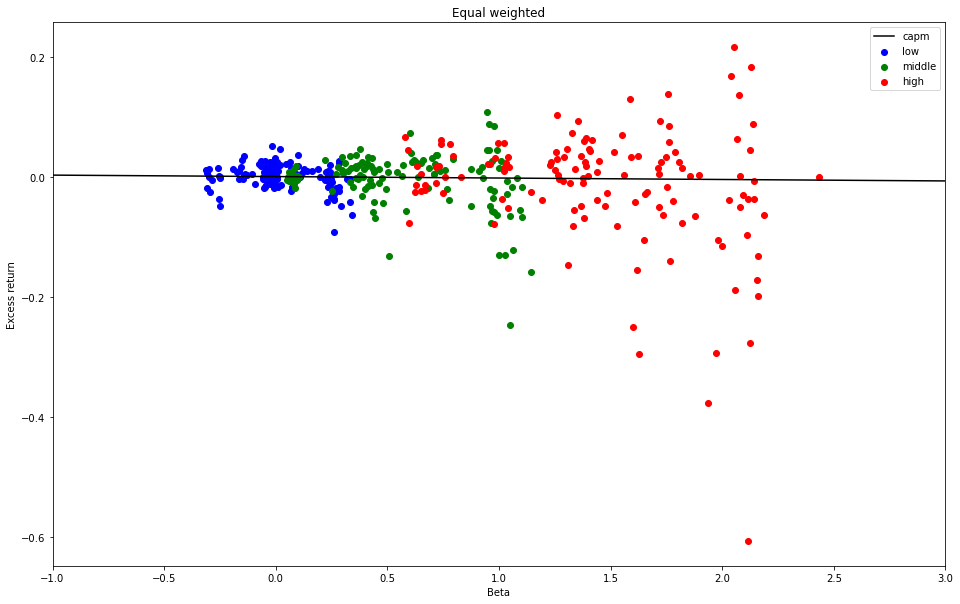

In [20]:
"""
Plot the values for the equal-weighted excess returns and betas
"""

fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.scatter(low_val['ew_beta'],low_val['ew_excess_ret'], color='blue', label='low')
ax.scatter(middle_val['ew_beta'],middle_val['ew_excess_ret'], color='green', label='middle')
ax.scatter(high_val['ew_beta'],high_val['ew_excess_ret'], color='red', label='high')
ax.plot(capm['betas'],capm['excess returns'], color='black', label='capm')
ax.set_xlim([-1,3])
#ax.set_ylim([-0.1,0.1])
ax.set_xlabel('Beta')
ax.set_ylabel('Excess return')
ax.set_title('Equal weighted')
ax.legend();

## Step 2 in Baker & Wurgler
Alpha regressed on betas. The slope should be negative if there exists a low risk anomaly

In [21]:
"""
Create a dictionary that contains the 3 groups of weighted excess return, backward beta and alphas (both equal and value weighted)
"""
dict_ = {}
dict_[0] = low_val
dict_[1] = middle_val
dict_[2] = high_val

### Second regression

In [24]:
"""
EQUAL WEIGHTED 
Based on the equal weighted excess return (backward beta groups) we estimate alpha and beta so we get a new 
timeserie with 264 alphas and betas for the 3 equal weighted groups
"""
descriptive20 = pd.DataFrame()

for i in dict_.keys():    
    Y = dict_[i]['ew_excess_ret'].astype('float64')
    X = df_mkt['EUROPE IM (excess)'].iloc[:-12].astype('float64').to_numpy().reshape(-1,1)

    lm = LinearRegression()
    lm.fit(X,Y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)

    descriptive20.loc['Alpha', i] = params[0]
    descriptive20.loc['Alpha T-stat', i] = ts_b[0]
    descriptive20.loc['Alpha p-value', i] = p_values[0]
    descriptive20.loc['Beta', i] = params[1]
    descriptive20.loc['Beta T-stat', i] = ts_b[1]
    descriptive20.loc['Beta p-value', i] = p_values[1]
    
descriptive20.columns=['Low beta portfolio', 'Middle beta portfolio', 'High beta portfolio']
descriptive20

,Low beta portfolio,Middle beta portfolio,High beta portfolio
Alpha,-0.0001,-0.0033,-0.0119
Alpha T-stat,-0.0680,-1.1260,-2.0750
Alpha p-value,0.9456,0.2621,0.0400
Beta,0.1019,0.6346,1.6167
Beta T-stat,2.7790,10.7000,13.8550
Beta p-value,0.0063,0.0000,0.0000


In [25]:
"""
VALUE WEIGHTED 
Based on the value weighted excess return (backward beta groups) we estimate alpha and beta so we get a new 
timeserie with 264 alphas and betas for the 3 value weighted groups
"""
descriptive21 = pd.DataFrame()

for i in dict_.keys():    
    Y = dict_[i]['vw_excess_ret'].astype('float64')
    X = df_mkt['EUROPE IM (excess)'].iloc[:-12].astype('float64').to_numpy().reshape(-1,1)

    lm = LinearRegression()
    lm.fit(X,Y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)

    descriptive21.loc['Alpha', i] = params[0]
    descriptive21.loc['Alpha T-stat', i] = ts_b[0]
    descriptive21.loc['Alpha p-value', i] = p_values[0]
    descriptive21.loc['Beta', i] = params[1]
    descriptive21.loc['Beta T-stat', i] = ts_b[1]
    descriptive21.loc['Beta p-value', i] = p_values[1]
    
descriptive21.columns=['Low beta portfolio', 'Middle beta portfolio', 'High beta portfolio']
descriptive21

,Low beta portfolio,Middle beta portfolio,High beta portfolio
Alpha,0.0039,-0.0022,-0.0073
Alpha T-stat,1.1960,-0.5470,-1.2410
Alpha p-value,0.2338,0.5853,0.2167
Beta,0.0659,0.6927,1.5466
Beta T-stat,1.0060,8.4650,12.9400
Beta p-value,0.3165,0.0000,0.0000


### Third regression

In [26]:
"""
We collect the six alphas in one dataframe
"""

s1 = descriptive20.iloc[0,:].copy()
s2 = descriptive21.iloc[0,:].copy()
alphas = pd.concat([s1,s2])

In [27]:
"""
We collect the six betas in one dataframe
"""
s1 = descriptive20.iloc[3,:].copy()
s2 = descriptive21.iloc[3,:].copy()
betas = pd.concat([s1,s2])

In [28]:
"""
We perform the third regression in order to determine whether there is a low risk anomaly
"""
Y = alphas.tolist()
X = betas.tolist() 
X2 = sm.add_constant(X)
result = sm.OLS(Y, X2).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     33.28
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00448
Time:                        09:38:50   Log-Likelihood:                 29.912
No. Observations:                   6   AIC:                            -55.82
Df Residuals:                       4   BIC:                            -56.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.895      0.1

/Users/julielaustsen/opt/anaconda3/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [29]:
"""
We create a datafram in order to draw the linear regression
"""
line = pd.DataFrame()
line['fik betas']=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1, 1.25, 1.5, 1.75, 2]
line['line']=0.0025*10000-0.0077*10000*line['fik betas'] #the values is from above regression. We multiply with 1000 to get bps

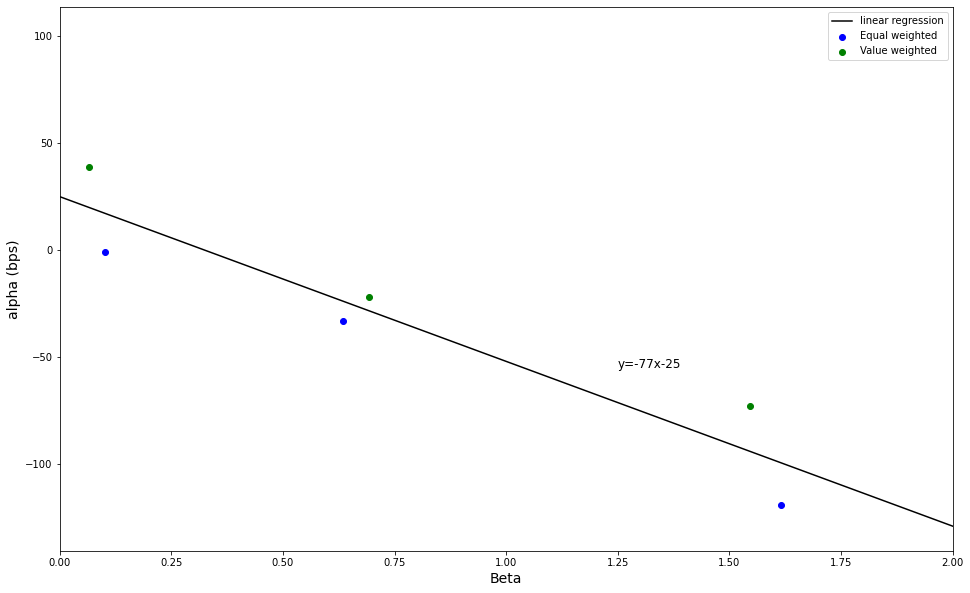

In [32]:
"""
We plot the linear regression along with the 6 pairs of alpha and beta
"""
fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.scatter(descriptive20.iloc[3,:],descriptive20.iloc[0,:]*10000, color='blue', label='Equal weighted')
ax.scatter(descriptive21.iloc[3,:],descriptive21.iloc[0,:]*10000, color='green', label='Value weighted')
ax.plot(line['fik betas'],line['line'], color='black', label='linear regression')
ax.set_xlim([-0,2])
ax.set_xlabel('Beta', fontsize=14)
ax.set_ylabel('alpha (bps)', fontsize=14)
ax.text(1.25,-55,'y=-77x-25', fontsize=12)
ax.legend();